In [1]:
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np 
import time, math, random
from typing import Tuple

# import gym 
import gym


#rendering episode number
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt 


In [2]:
env = gym.make('CartPole-v1')

In [3]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

In [4]:
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(6, 12, 2)

In [5]:
def policy( state : tuple ):
    """Choosing action based on epsilon-greedy policy"""
    return np.argmax(Q_table[state])

In [6]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Temperal diffrence for updating Q-value of state-action pair"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

In [7]:
# Adaptive learning of Learning Rate
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Decaying learning rate"""
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

In [8]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [9]:
def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

    return im

# Training

In [10]:
total =0
R2 = []
E2 = []
n_episodes = 100
for e in range(n_episodes):
    
    # Siscretize state into buckets
    current_state, done = discretizer(*env.reset()), False
    
    while done==False:
        
        # policy action 
        action = policy(current_state) # exploit
        
        # insert random action
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # increment enviroment
        obs, reward, done, _ = env.step(action)
        new_state = discretizer(*obs)
        
        # Update Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state )
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        total += reward
        
        
        current_state = new_state
        
        # Render the cartpole environment
        
    R2.append(total)
    E2.append(e)
    total = 0


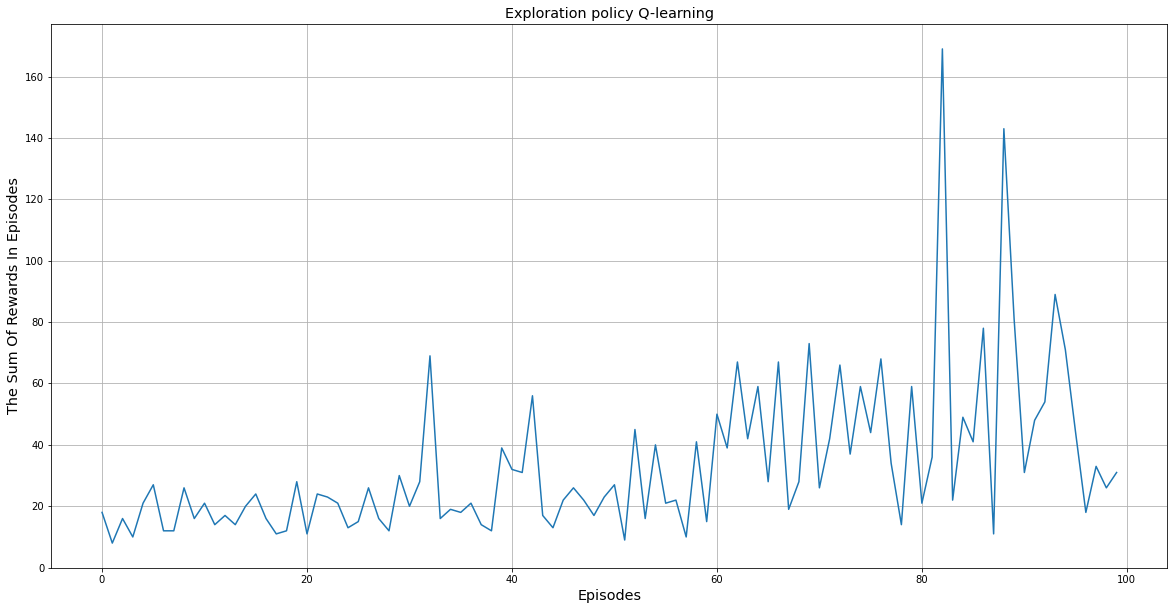

In [23]:
import numpy as np
import matplotlib.pyplot as plt


t = np.array(R2)              # white noise 1
s = np.array(E2)              # white noise 2


params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         }
plt.rcParams.update(params)

fig, ax = plt.subplots()
ax.plot(s, t) 
ax.set(xlabel='Episodes', ylabel='The Sum Of Rewards In Episodes',
       title='Exploration policy Q-learning')
ax.grid()

fig.set_size_inches(20, 10)
fig.savefig('cart.png', dpi=100)


plt.show()